In [6]:
# Import necessary libraries

import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import pandas_datareader.data as web
import yfinance as yf
style.use('ggplot')

In [7]:
#Need to provide a start date and end date for which the stock data has to be retreived for Tesla from yahoo finance api

start = dt.datetime(2000,1,1)
end = dt.datetime(2022,12,31)

stock_symbol = 'TSLA'

# Download stock data from Yahoo Finance

df = yf.download(stock_symbol, start=start, end=end)
df.to_csv('Tesla.csv')


[*********************100%%**********************]  1 of 1 completed


                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
2010-06-29  1.266667  1.666667  1.169333  1.592667   1.592667  281494500
2010-06-30  1.719333  2.028000  1.553333  1.588667   1.588667  257806500
2010-07-01  1.666667  1.728000  1.351333  1.464000   1.464000  123282000
2010-07-02  1.533333  1.540000  1.247333  1.280000   1.280000   77097000
2010-07-06  1.333333  1.333333  1.055333  1.074000   1.074000  103003500


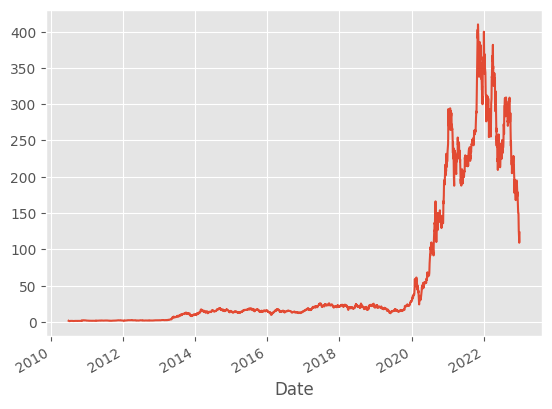

In [8]:
# Tesla closing prices plotted
df = pd.read_csv('Tesla.csv',parse_dates=True,index_col=0)
print(df.head())

df['Adj Close'].plot()
plt.show()

In [10]:
#Since there are too many datapoints,we will resample the data for 10 days i.e convert 10 day data into 1 point to make
#it easier for us to understand the data
#df_ohlc - ohlc stands for Open High Low Close.In Financial Markets,the stock prices are generally represented with
#the help of candlestick charts,the candlestick chart represent Open,High Low and Close
#we use the resample.ohlc method inbuilt in pandas to convert the data into 10 day data
#For Volume in place of taking the ohlc or mean,we take the sum over 10 days

df['100ma'] = df['Adj Close'].rolling(window=100).mean()
print(df.head())
print(df.tail())

                Open      High       Low     Close  Adj Close     Volume  \
Date                                                                       
2010-06-29  1.266667  1.666667  1.169333  1.592667   1.592667  281494500   
2010-06-30  1.719333  2.028000  1.553333  1.588667   1.588667  257806500   
2010-07-01  1.666667  1.728000  1.351333  1.464000   1.464000  123282000   
2010-07-02  1.533333  1.540000  1.247333  1.280000   1.280000   77097000   
2010-07-06  1.333333  1.333333  1.055333  1.074000   1.074000  103003500   

            100ma  
Date               
2010-06-29    NaN  
2010-06-30    NaN  
2010-07-01    NaN  
2010-07-02    NaN  
2010-07-06    NaN  
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-12-23  126.370003  128.619995  121.019997  123.150002  123.150002   
2022-12-27  117.500000  119.669998  108.760002  109.099998  109.099998   
2022-12-28  110.349998  116.269

In [11]:
#Candlestick representation:
df_ohlc = df['Adj Close'].resample('10D').ohlc()
df_volume = df['Volume'].resample('10D').sum()
df_ohlc.reset_index(inplace=True)
df_ohlc['Date'] = df_ohlc['Date'].map(mdates.date2num)
print(df_ohlc.head())

      Date      open      high       low     close
0  14789.0  1.592667  1.592667  1.053333  1.164000
1  14799.0  1.160000  1.376000  1.136667  1.376000
2  14809.0  1.460667  1.460667  1.348000  1.381333
3  14819.0  1.356667  1.463333  1.306000  1.306000
4  14829.0  1.306667  1.306667  1.173333  1.276667


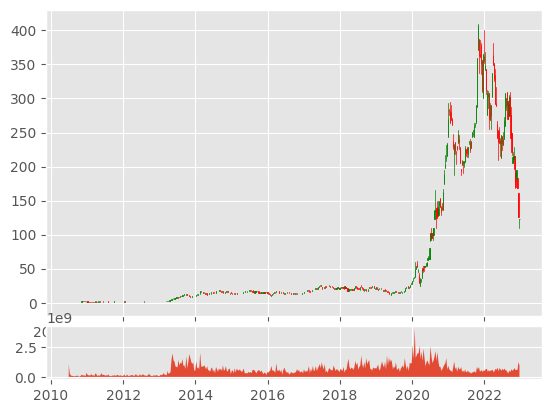

In [12]:
# Plotting candlestick chart
ax1 = plt.subplot2grid((6,1) ,(0,0), rowspan=5, colspan=1)
ax2 = plt.subplot2grid((6,1) ,(5,0), rowspan=1, colspan=1, sharex=ax1)
ax1.xaxis_date()
candlestick_ohlc(ax1, df_ohlc.values, width=2, colorup='g')
ax2.fill_between(df_volume.index.map(mdates.date2num), df_volume.values, 0)
plt.show()

         Date      Open      High       Low     Close  Adj Close     Volume
0  2010-06-29  1.266667  1.666667  1.169333  1.592667   1.592667  281494500
1  2010-06-30  1.719333  2.028000  1.553333  1.588667   1.588667  257806500
2  2010-07-01  1.666667  1.728000  1.351333  1.464000   1.464000  123282000
3  2010-07-02  1.533333  1.540000  1.247333  1.280000   1.280000   77097000
4  2010-07-06  1.333333  1.333333  1.055333  1.074000   1.074000  103003500
         Date        MMM       AOS       ABT  ABBV  ACN       ADM       ADBE  \
0  2000-01-03  24.772848  2.349174  9.081112   0.0  0.0  6.514027  16.274670   
1  2000-01-04  23.788494  2.315324  8.821648   0.0  0.0  6.446170  14.909398   
2  2000-01-05  24.477533  2.308554  8.805430   0.0  0.0  6.344389  15.204173   
3  2000-01-06  26.446232  2.274704  9.113540   0.0  0.0  6.378318  15.328290   
4  2000-01-07  26.971224  2.369482  9.210837   0.0  0.0  6.480098  16.072985   

         ADP        AES  ...       ALB        ARE  ALGN  ALLE  

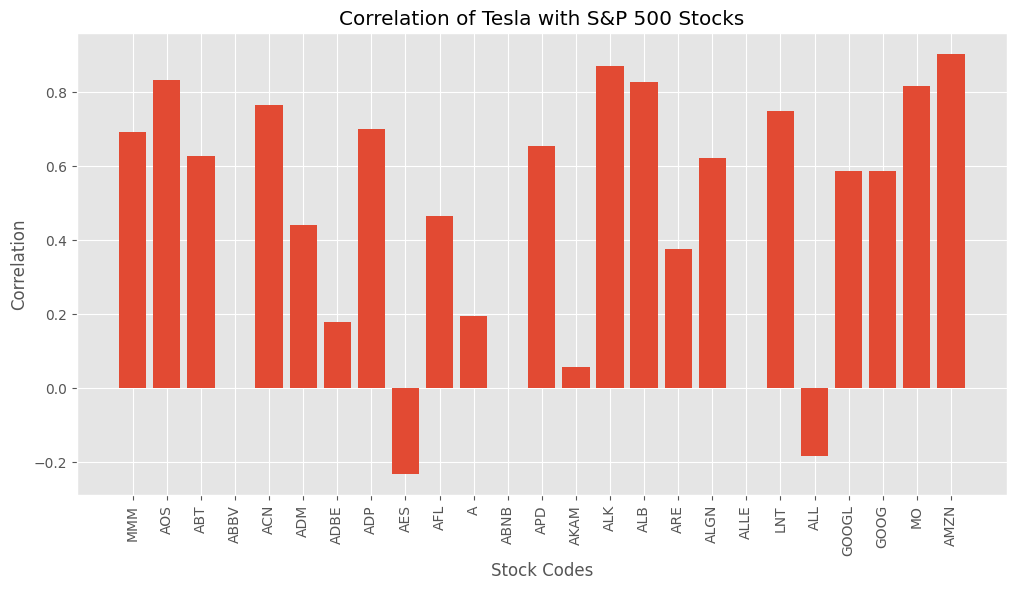

0.6915420825412347


In [14]:
#Tesla correlation with 25 other companies
def tesla_corr_heatmap():
    df2 = pd.read_csv('./Tesla_data/S&P500_joined_closes.csv').fillna(value = 0)
    df1 = pd.read_csv('Tesla.csv').fillna(value = 0)

    # print(df2.describe)
    print(df1.head())
    print(df2.head())

    correlation = df1["Adj Close"].corr(df2["MMM"])

    print(df1["Adj Close"].isna().any())
    # for column in df2:
    #     print(df2[column])
    corr_arr = []
    tickers = []
    for column in df2.columns[1:]:
        print(df2[column].isna().any())
        corr_arr.append(df1["Adj Close"].corr(df2[column]))
        tickers.append(column)
    
    print(corr_arr)
    print(tickers)

    plt.figure(figsize=(12, 6)) 
    plt.bar(tickers,corr_arr)
    plt.xlabel('Stock Codes')
    plt.ylabel('Correlation')
    plt.title('Correlation of Tesla with S&P 500 Stocks')
    plt.xticks(rotation=90)
    plt.show()

    print(correlation)


tesla_corr_heatmap()

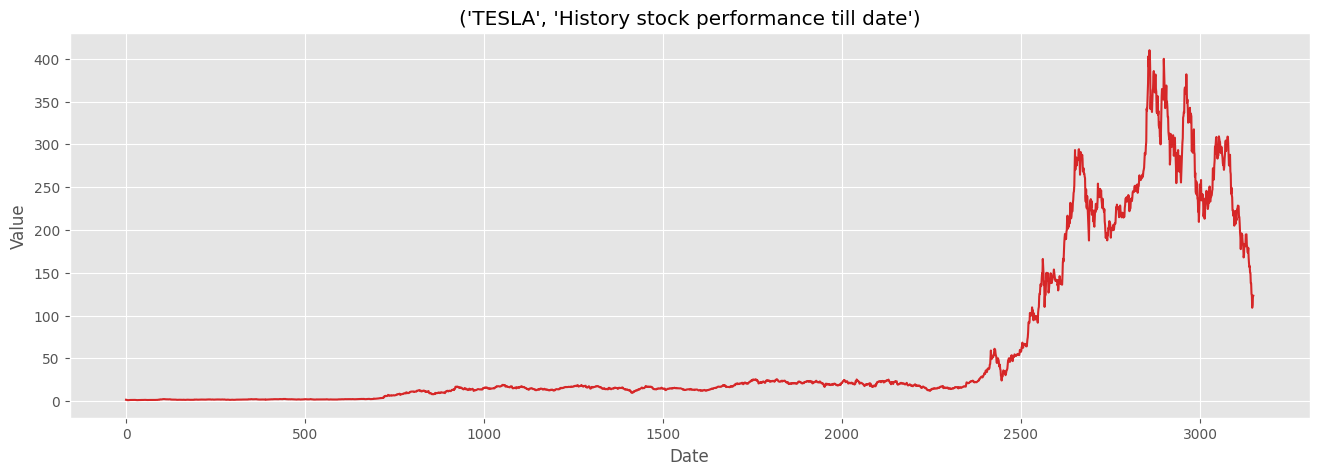

   level_0  index       Date      Open      High       Low  Adj Close  \
0        0      0 2010-06-29  1.266667  1.666667  1.169333   1.592667   
1        1      1 2010-06-30  1.719333  2.028000  1.553333   1.588667   
2        2      2 2010-07-01  1.666667  1.728000  1.351333   1.464000   
3        3      3 2010-07-02  1.533333  1.540000  1.247333   1.280000   
4        4      4 2010-07-06  1.333333  1.333333  1.055333   1.074000   

      Volume  100ma  
0  281494500    NaN  
1  257806500    NaN  
2  123282000    NaN  
3   77097000    NaN  
4  103003500    NaN  


In [19]:
#Visualising part is complete

#Now analyze the results of all the data that we have

#We can start with predicting the stock prices with linear regression

x = df.index
y = df['Adj Close']

def df_plot(data, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()


stock_name= "TESLA"
title = (stock_name,"History stock performance till date")

df_plot(df , x , y , title=title,xlabel='Date', ylabel='Value',dpi=100)


In [20]:
#Gives a summary of the dataset

print(df.describe())
print(len(df))

        level_0     index         Open         High          Low    Adj Close  \
count  3150.000  3150.000  3150.000000  3150.000000  3150.000000  3150.000000   
mean   1574.500  1574.500    58.860577    60.176703    57.402961    58.807496   
std     909.471   909.471    95.658595    97.854579    93.175266    95.526397   
min       0.000     0.000     1.076000     1.108667     0.998667     1.053333   
25%     787.250   787.250     8.976167     9.117500     8.765667     8.957666   
50%    1574.500  1574.500    16.229000    16.491000    15.945000    16.222334   
75%    2361.750  2361.750    24.622500    25.086666    24.158668    24.448000   
max    3149.000  3149.000   411.470001   414.496674   405.666656   409.970001   

             Volume        100ma  
count  3.150000e+03  3051.000000  
mean   9.359654e+07    57.524872  
std    8.169856e+07    93.434799  
min    1.777500e+06     1.399193  
25%    4.234658e+07    10.279910  
50%    7.596600e+07    15.982487  
75%    1.172978e+08    23

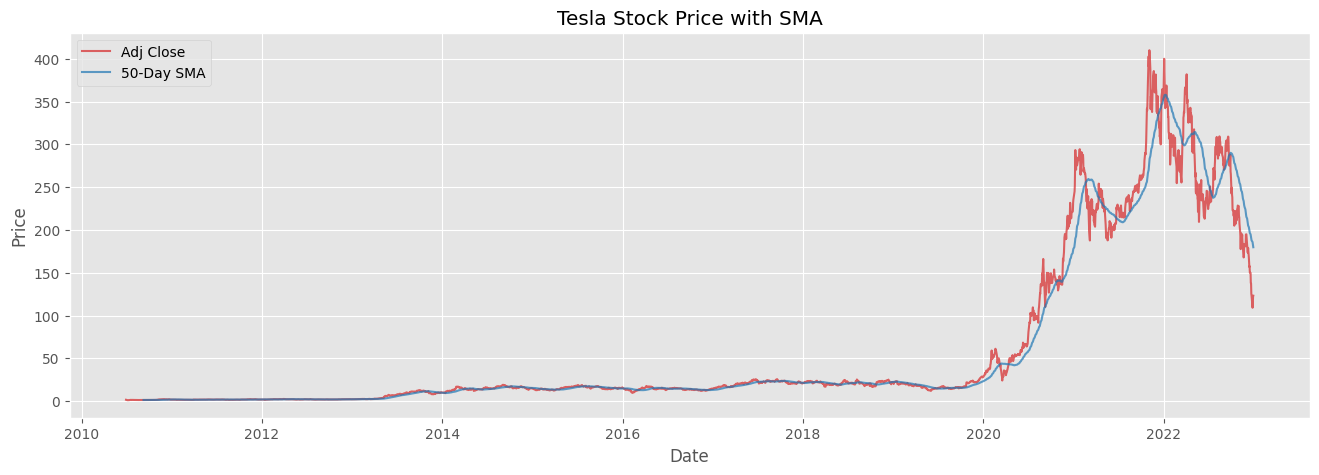

In [21]:
#SIMPLE MOVING AVERAGE
window = 50
df['SMA'] = df['Adj Close'].rolling(window=window).mean()

# Plot the stock prices and SMA
plt.figure(figsize=(16,5), dpi=100)
plt.plot(df['Date'], df['Adj Close'], color='tab:red', label='Adj Close', alpha=0.7)
plt.plot(df['Date'], df['SMA'], color='tab:blue', label=f'{window}-Day SMA', alpha=0.7)
plt.gca().set(title='Tesla Stock Price with SMA', xlabel='Date', ylabel='Price')
plt.legend()
plt.show()

In [25]:
#'Adj Close' is the target variable for regression

x = df[['Open', 'High','Low', 'Volume']]
y = df['Adj Close']


# Linear regression Model for stock prediction 
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.15 , shuffle=False,random_state = 0)
print(train_x.shape )
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)



regression = LinearRegression()
regression.fit(train_x, train_y)
print("regression coefficient",regression.coef_)
print("regression intercept",regression.intercept_)

#Here we will compute the coefficient of determination denoted by R², which takes values between 0 and 1, the higher the value R² the more successful the linear regression is at explaining the variation of Y values, in our case the Y values represent the close stock prices of the subjected company. The below is the math behind The coefficient of determination R²

# the coefficient of determination R² 
regression_confidence = regression.score(test_x, test_y)
print("linear regression confidence: ", regression_confidence)


predicted=regression.predict(test_x)
print(test_x.head())

print(predicted.shape)


dfr=pd.DataFrame({'Actual_Price':test_y, 'Predicted_Price':predicted})
#Adding actual dates to the newly created dataframe to make it easier to understand
print(dfr.head())
num_data_points = len(dfr)
print(num_data_points)
start_date = '2021-01-29'  # Replace with your desired start date
date_range = pd.date_range(start=start_date, periods=num_data_points)
dfr['Date'] = date_range


print(dfr.head(10))
print(dfr.describe())
dfr.to_csv('ActualvPredicted_prices.csv')

(2677, 4)
(473, 4)
(2677,)
(473,)
regression coefficient [-5.67354705e-01  9.45177520e-01  6.18120076e-01 -7.19608817e-10]
regression intercept 0.039399478591409576
linear regression confidence:  0.9949992091767349
            Open        High         Low     Volume
2677  259.696655  266.613342  254.003326   77989500
2678  260.299988  264.896667  258.756653   53871300
2679  265.000000  265.596680  259.123322   56874900
2680  254.213333  256.166656  236.733337  111809100
2681  220.710007  237.869995  206.333328  199820700
(473,)
      Actual_Price  Predicted_Price
2677    266.049988       261.644651
2678    262.459991       262.635267
2679    260.433319       260.854813
2680    238.166672       244.182403
2681    232.946671       227.042890
473
      Actual_Price  Predicted_Price       Date
2677    266.049988       261.644651 2021-01-29
2678    262.459991       262.635267 2021-01-30
2679    260.433319       260.854813 2021-01-31
2680    238.166672       244.182403 2021-02-01
2681    232

In [26]:
#Accuracy of the model
x2 = dfr.Actual_Price.mean()
y2 = dfr.Predicted_Price.mean()
Accuracy1 = x2/y2*100
print("The accuracy of the model is " , Accuracy1)

The accuracy of the model is  99.67054996048016


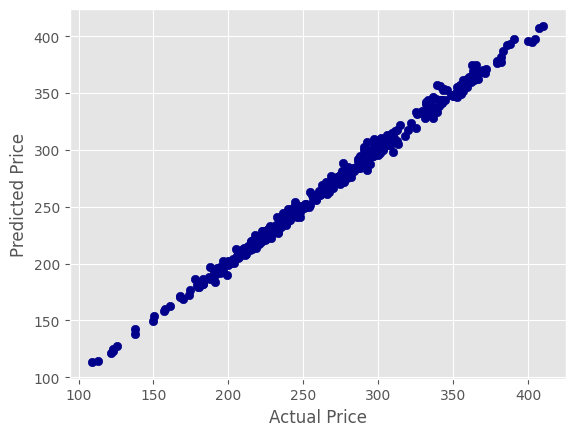

In [27]:
#Scatterplot
plt.scatter(dfr.Actual_Price, dfr.Predicted_Price,  color='Darkblue')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.show()


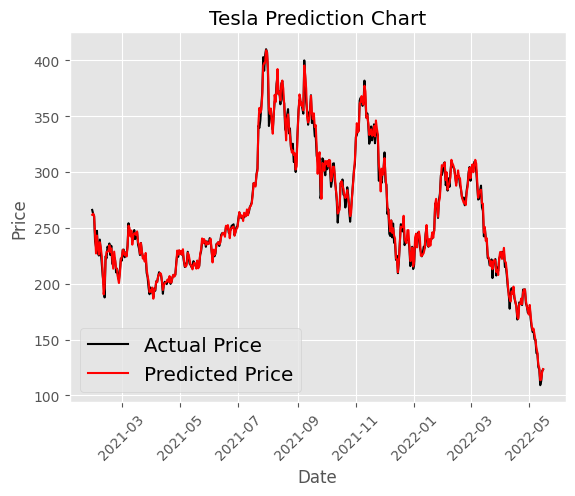

Mean Squared Error: 16.37432736513001
R-squared: 0.9949992091767349


In [28]:
#Prediction Chart- Tesla
x = dfr['Date']
y_actual = dfr['Actual_Price']
y_predicted = dfr['Predicted_Price']
plt.plot(x, y_actual, color='black', label='Actual Price')
plt.plot(x, y_predicted, color='red', label='Predicted Price')
plt.title("Tesla Prediction Chart")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(fontsize="x-large")
plt.xticks(rotation=45)
plt.show()

mse = mean_squared_error(test_y, predicted)
print(f'Mean Squared Error: {mse}')

# R-squared
r2 = r2_score(test_y, predicted)
print(f'R-squared: {r2}')

In [38]:
print(train_x.head())

       Open      High       Low     Volume
0  1.266667  1.666667  1.169333  281494500
1  1.719333  2.028000  1.553333  257806500
2  1.666667  1.728000  1.351333  123282000
3  1.533333  1.540000  1.247333   77097000
4  1.333333  1.333333  1.055333  103003500


In [41]:
print(train_y.head())


0    1.592667
1    1.588667
2    1.464000
3    1.280000
4    1.074000
Name: Adj Close, dtype: float64


C:\Users\abc\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


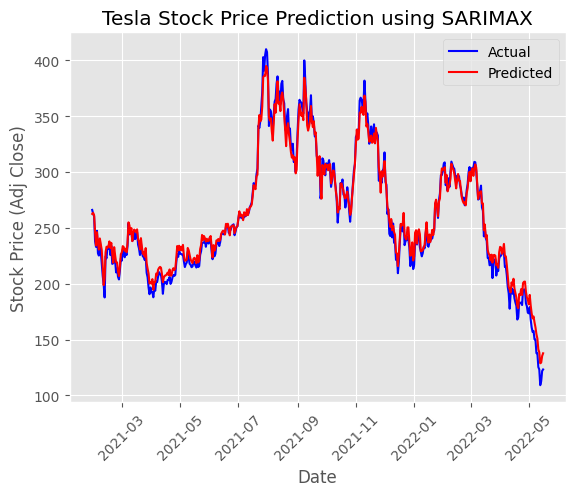

Mean Squared Error: 45.43853841602037
R-squared: 0.9861228726611814


In [57]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMAX model
order = (5, 1, 0)  # Specify ARIMA order
seasonal_order = (1, 0, 1, 12)  # Specify seasonal order if applicable
model = SARIMAX(train_y, exog=train_x, order=order, seasonal_order=seasonal_order)
fitted_model = model.fit(maxiter=1000)

# Forecast using the SARIMAX model
forecast = fitted_model.forecast(steps=len(test_y), exog=test_x)
x = dfr['Date']

# Visualize results (optional)
plt.plot(x, test_y, color='blue',label='Actual')
plt.plot(x, forecast, color='red', label='Predicted')
plt.title('Tesla Stock Price Prediction using SARIMAX')
plt.xlabel('Date')
plt.ylabel('Stock Price (Adj Close)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Evaluate the model
mse = mean_squared_error(test_y, forecast)
print(f'Mean Squared Error: {mse}')

r2 = r2_score(test_y, forecast)
print(f'R-squared: {r2}')


In [81]:
df2 = pd.read_csv('./Tesla_data/S&P500_joined_closes.csv').fillna(value = 0)


In [82]:
print(df2.head())

         Date        MMM       AOS        ABT  ABBV        ACN        ADM  \
0  30-06-2010  53.037037  6.571832  16.698841   0.0  30.078590  18.360682   
1  01-07-2010  52.741604  6.569104  16.584608   0.0  29.790638  18.318018   
2  02-07-2010  52.150738  6.605925  16.584608   0.0  29.526041  18.133129   
3  06-07-2010  52.466312  6.570469  16.666714   0.0  29.891811  18.332237   
4  07-07-2010  54.064343  6.910039  17.030821   0.0  30.553301  18.730453   

        ADBE        ADP       AES  ...        ALB        ARE   ALGN  ALLE  \
0  26.430000  25.833788  6.594038  ...  32.992126  42.017048  14.87   0.0   
1  26.660000  25.480858  6.486991  ...  32.884113  42.043575  14.30   0.0   
2  26.730000  25.301195  6.508402  ...  32.568394  40.942921  14.20   0.0   
3  26.340000  25.288370  6.351400  ...  32.485313  40.332916  14.10   0.0   
4  26.790001  25.801701  7.036496  ...  33.955872  42.892265  14.88   0.0   

         LNT        ALL      GOOGL       GOOG        MO    AMZN  
0  10.00

In [83]:
print(df.head())


   level_0  index       Date      Open      High       Low  Adj Close  \
0        0      0 2010-06-29  1.266667  1.666667  1.169333   1.592667   
1        1      1 2010-06-30  1.719333  2.028000  1.553333   1.588667   
2        2      2 2010-07-01  1.666667  1.728000  1.351333   1.464000   
3        3      3 2010-07-02  1.533333  1.540000  1.247333   1.280000   
4        4      4 2010-07-06  1.333333  1.333333  1.055333   1.074000   

      Volume  100ma  SMA  
0  281494500    NaN  NaN  
1  257806500    NaN  NaN  
2  123282000    NaN  NaN  
3   77097000    NaN  NaN  
4  103003500    NaN  NaN  


In [84]:
df2.set_index('Date', inplace=True)
df.set_index('Date', inplace=True)


In [95]:
df_selected = df[['Adj Close']]
merged_df = pd.merge(df_selected, df2, how='outer', left_index=True, right_index=True)

In [96]:
print(merged_df.tail())

            Adj Close         MMM        AOS         ABT        ABBV  \
Date                                                                   
31-12-2015        NaN  115.989868  33.673927   38.660778   41.931835   
31-12-2018        NaN  158.270462  38.915489   66.510468   72.990082   
31-12-2019        NaN  151.479385  44.227039   81.196114   74.061691   
31-12-2020        NaN  155.668091  51.949829  103.964111   94.590317   
31-12-2021        NaN  163.218857  82.744797  135.702591  125.262207   

                   ACN        ADM        ADBE         ADP        AES  ...  \
Date                                                                  ...   
31-12-2015   91.952515  29.484419   93.940002   71.796616   7.275659  ...   
31-12-2018  131.469025  36.076107  226.240005  118.821327  12.439726  ...   
31-12-2019  198.799072  42.246067  329.809998  157.685074  17.684261  ...   
31-12-2020  250.567123  47.501843  500.119995  166.920303  21.600821  ...   
31-12-2021  402.574585  65.232170

In [103]:
x = merged_df[['MMM', 'AOS','ABT', 'AES','ACN','ADM','ADBE','ADP','AES','ALB','ARE','ALGN','ALLE','LNT','ALL','GOOGL','GOOG','MO','AMZN']]
y = merged_df['Adj Close']


# Linear regression Model for stock prediction 
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.15 , shuffle=False,random_state = 0)
print(train_x.shape )
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)


(5354, 19)
(945, 19)
(5354,)
(945,)


In [104]:
print(merged_df.head())

                     Adj Close  MMM  AOS  ABT  ABBV  ACN  ADM  ADBE  ADP  AES  \
Date                                                                            
2010-06-29 00:00:00   1.592667  NaN  NaN  NaN   NaN  NaN  NaN   NaN  NaN  NaN   
2010-06-30 00:00:00   1.588667  NaN  NaN  NaN   NaN  NaN  NaN   NaN  NaN  NaN   
2010-07-01 00:00:00   1.464000  NaN  NaN  NaN   NaN  NaN  NaN   NaN  NaN  NaN   
2010-07-02 00:00:00   1.280000  NaN  NaN  NaN   NaN  NaN  NaN   NaN  NaN  NaN   
2010-07-06 00:00:00   1.074000  NaN  NaN  NaN   NaN  NaN  NaN   NaN  NaN  NaN   

                     ...  ALB  ARE  ALGN  ALLE  LNT  ALL  GOOGL  GOOG  MO  \
Date                 ...                                                    
2010-06-29 00:00:00  ...  NaN  NaN   NaN   NaN  NaN  NaN    NaN   NaN NaN   
2010-06-30 00:00:00  ...  NaN  NaN   NaN   NaN  NaN  NaN    NaN   NaN NaN   
2010-07-01 00:00:00  ...  NaN  NaN   NaN   NaN  NaN  NaN    NaN   NaN NaN   
2010-07-02 00:00:00  ...  NaN  NaN   NaN   NaN 

In [105]:
print(merged_df.tail())

            Adj Close         MMM        AOS         ABT        ABBV  \
Date                                                                   
31-12-2015        NaN  115.989868  33.673927   38.660778   41.931835   
31-12-2018        NaN  158.270462  38.915489   66.510468   72.990082   
31-12-2019        NaN  151.479385  44.227039   81.196114   74.061691   
31-12-2020        NaN  155.668091  51.949829  103.964111   94.590317   
31-12-2021        NaN  163.218857  82.744797  135.702591  125.262207   

                   ACN        ADM        ADBE         ADP        AES  ...  \
Date                                                                  ...   
31-12-2015   91.952515  29.484419   93.940002   71.796616   7.275659  ...   
31-12-2018  131.469025  36.076107  226.240005  118.821327  12.439726  ...   
31-12-2019  198.799072  42.246067  329.809998  157.685074  17.684261  ...   
31-12-2020  250.567123  47.501843  500.119995  166.920303  21.600821  ...   
31-12-2021  402.574585  65.232170